In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
from pkg_resources.extern import packaging

def parse_version(v):
    try:
        return packaging.version.Version(v)
    except packaging.version.InvalidVersion:
        return packaging.version.LegacyVersion(v)

In [3]:
def read_iff_file(filename, record_types=3, callsigns=None, chunksize=50000, encoding='latin-1'):
    """
    Read IFF file and return data frames for requested record types
    
    From IFF 2.15 specification, record types include:
    2. header
    3. track point
    4. flight plan
    5. data source program
    6. sectorization
    7. minimum safe altitude
    8. flight progress
    9. aircraft state
    Parameters
    ----------
    filename : str
        File to read
    record_types : int, sequence of ints, or 'all'
        Record types to return
    callsigns : None, string, or list of strings
        If None, return records for all aircraft callsigns.
        Otherwise, only return records that match the given callsign
        (in the case of a single string) or match one of the specified
        callsigns (in the case of a list of strings).
    chunksize: int
        Number of rows that are read at a time by pd.read_csv.  This
        limits memory usage when working with large files, as we can
        extract out the desired rows from each chunk, intead of
        reading everything into one large DataFrame and then taking a
        subset.
    encoding: str
        Encoding argument passed on to open and pd.read_csv.  Using
        'latin-1' instead of the default will suppress errors that
        might otherwise occur with minor data corruption.  See
        http://python-notes.curiousefficiency.org/en/latest/python3/text_file_processing.html
    
    Returns
    -------
    DataFrame or dict of DataFrames
       If record_types is a scalar, return a DataFrame containing the
       data for that record type only.  Otherwise, return a dictionary
       mapping each requested record type to a corresponding DataFrame.
    """
    # Note default record_type of 3 (track point) is used for
    # consistency with the behavior of other functions that expect
    # flight tracking data

    # Determine file format version.  This is in record type 1, which
    # for now we assume to occur on the first line.
    with open(filename, 'r') as f:
        version = parse_version(f.readline().split(',')[2])

    # Columns for each record type, from version 2.6 specification.
    cols = {0:['recType','comment'],
            1:['recType','fileType','fileFormatVersion'],
            2:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','opsType','estOrig','estDest'],
            3:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','significance','coord1Accur','coord2Accur','altAccur','groundSpeed','course','rateOfClimb','altQualifier','altIndicator','trackPtStatus','leaderDir','scratchPad','msawInhibitInd','assignedAltString','controllingFac','controllingSeg','receivingFac','receivingSec','activeContr','primaryContr','kybrdSubset','kybrdSymbol','adsCode','opsType','airportCode'],
            4:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','altcode','alt','maxAlt','assignedAltString','requestedAltString','route','estTime','fltCat','perfCat','opsType','equipList','coordinationTime','coordinationTimeType','leaderDir','scratchPad1','scratchPad2','fixPairScratchPad','prefDepArrRoute','prefDepRoute','prefArrRoute'],
            5:['recType','dataSource','programName','programVersion'],
            6:['recType','recTime','Source','msgType','rectypeCat','sectorizationString'],
            7:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','significance','coord1Accur','coord2Accur','altAccur','msawtype','msawTimeCat','msawLocCat','msawMinSafeAlt','msawIndex1','msawIndex2','msawVolID'],
            8:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','depTime','depTimeType','arrTime','arrTimeType'],
            9:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','pitchAngle','trueHeading','rollAngle','trueAirSpeed','fltPhaseIndicator'],
            10:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','configType','configSpec']}

    # For newer versions, additional columns are supported.  However,
    # this code could be commented out, and it should still be
    # compatible with newer versions, but just ignoring the additional
    # columns.
    if version >= parse_version('2.13'):
        cols[2] += ['modeSCode']
        cols[3] += ['trackNumber','tptReturnType','modeSCode']
        cols[4] += ['coordinationPoint','coordinationPointType','trackNumber','modeSCode']
    if version >= parse_version('2.15'):
        cols[3] += ['sensorTrackNumberList','spi','dvs','dupM3a','tid']

    # Determine the record type of each row
    with open(filename, 'r', encoding=encoding) as f:
        # An alternative, using less memory, would be to directly
        # create skiprows indices for a particular record type, using
        # a comprehension on enumerate(f); however, that would not
        # allow handling multiple record types.
        line_record_types = [int(line.split(',')[0]) for line in f]

    # Determine which record types to retrieve, and whether the result
    # should be a scalar or dict:
    if record_types == 'all':
        record_types = np.unique(line_record_types)
        scalar_result = False
    elif hasattr(record_types, '__getitem__'):
        scalar_result = False
    else:
        record_types = [record_types]
        scalar_result = True

    if callsigns is not None:
        callsigns = list(np.atleast_1d(callsigns))


    data_frames = dict()
    for record_type in record_types:
        # Construct list of rows to skip:
        skiprows = [i for i,lr in enumerate(line_record_types) if lr != record_type]
        
        # Passing usecols is necessary because for some records, the
        # actual data has extraneous empty columns at the end, in which
        # case the data does not seem to get read correctly without
        # usecols
        if callsigns is None:
            df = pd.concat((chunk for chunk in pd.read_csv(filename, header=None, skiprows=skiprows, names=cols[record_type], usecols=cols[record_type], na_values='?', encoding=encoding, chunksize=chunksize, low_memory=False)), ignore_index=True)
        else:
            df = pd.concat((chunk[chunk['AcId'].isin(callsigns)] for chunk in pd.read_csv(filename, header=None, skiprows=skiprows, names=cols[record_type], usecols=cols[record_type], na_values='?', encoding=encoding, chunksize=chunksize, low_memory=False)), ignore_index=True)

        # For consistency with other PARA-ATM data:
        df.rename(columns={'recTime':'time',
                           'AcId':'callsign',
                           'coord1':'latitude',
                           'coord2':'longitude',
                           'alt':'altitude',
                           'rateOfClimb':'rocd',
                           'groundSpeed':'tas',
                           'course':'heading'},
                  inplace=True)

#         if 'time' in df:
#             df['time'] = pd.to_datetime(df['time'], unit='s')
        if 'altitude' in df:
            df['altitude'] *= 100 # Convert 100s ft to ft

        # Store to dict of data frames
        data_frames[record_type] = df

    if scalar_result:
        result = data_frames[record_types[0]]
    else:
        result = data_frames

    return result

In [4]:
date = 20190801
import glob
file_path = glob.glob("/media/ypang6/paralab/Research/data/ZTL/IFF_ZTL_{}*.csv".format(date))[0]

In [5]:
df = read_iff_file(file_path, record_types=3, chunksize = 1e7)

In [6]:
df.shape

(1984654, 45)

In [7]:
df.head()

,recType,time,fltKey,bcnCode,cid,Source,msgType,callsign,recTypeCat,latitude,...,opsType,airportCode,trackNumber,tptReturnType,modeSCode,sensorTrackNumberList,spi,dvs,dupM3a,tid
0,3,1.564635e+09,187079,NaN,728,0/ZTL,TH_FIXM,SKQ74,1,36.10444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,1.564635e+09,187079,NaN,728,0/ZTL,TH_FIXM,SKQ74,1,36.11417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.564635e+09,187079,NaN,728,0/ZTL,TH_FIXM,SKQ74,1,36.12389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.564635e+09,187079,NaN,728,0/ZTL,TH_FIXM,SKQ74,1,36.13333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,1.564635e+09,187079,NaN,728,0/ZTL,TH_FIXM,SKQ74,1,36.14278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = df[['time', 'latitude', 'longitude']]

In [9]:
df.head()

,time,latitude,longitude
0,1.564635e+09,36.10444,-79.43917
1,1.564635e+09,36.11417,-79.43611
2,1.564635e+09,36.12389,-79.43250
3,1.564635e+09,36.13333,-79.42889
4,1.564635e+09,36.14278,-79.42583


In [10]:
t_start, t_end = 1564646400, 1564646400+300
lat_min, lon_min, lat_max, lon_max = 32, -85.5, 35, -82.5
interval = 100
resolution = 128

In [11]:
timestamp = np.arange(t_start, t_end + 1, interval)
lat = np.linspace(lat_min, lat_max, resolution).tolist()
lon = np.linspace(lon_min, lon_max, resolution).tolist()

In [15]:
for time_idx in range(len(timestamp)-1):
    temp_df = df.loc[(df['time'] >= timestamp[time_idx]) & (df['time'] <= timestamp[time_idx+1])]
    ys = temp_df['latitude'].to_numpy()
    xs = temp_df['longitude'].to_numpy()

# use euclidean distance

In [25]:
def data_coord2view_coord(p, resolution, pmin, pmax):
    dp = pmax - pmin
    dv = (p - pmin) / dp * resolution
    return dv

def nearest_neighbours(xs, ys, reso, n_neighbours):
    im = np.zeros([reso, reso])
    extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]

    xv = data_coord2view_coord(xs, reso, extent[0], extent[1])
    yv = data_coord2view_coord(ys, reso, extent[2], extent[3])
    for x in range(reso):
        for y in range(reso):
            xp = (xv - x)
            yp = (yv - y)
            d = np.sqrt(xp**2 + yp**2)
            im[y][x] = 1 / np.sum(d[np.argpartition(d.ravel(), n_neighbours)[:n_neighbours]])

    return im, extent

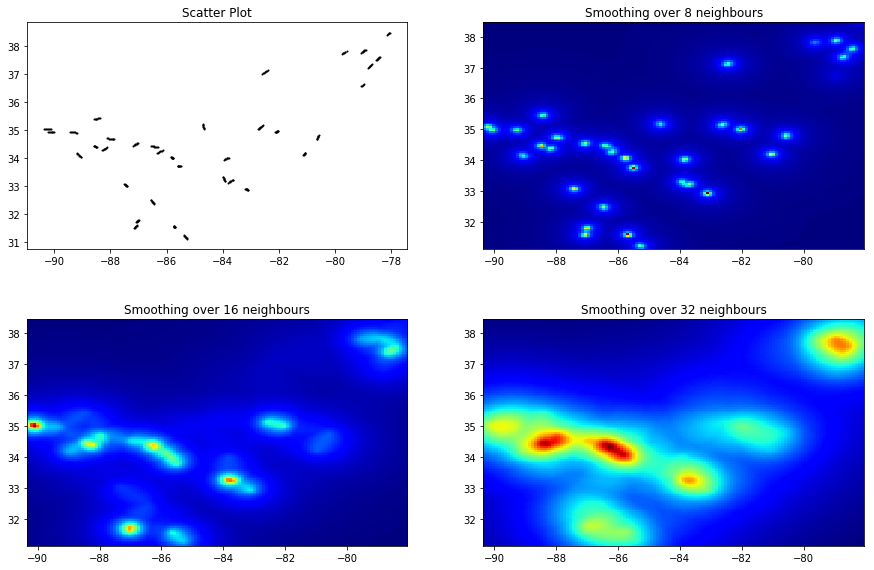

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, neighbours in zip(axes.flatten(), [0, 8, 16, 32]):
    if neighbours == 0:
        ax.plot(xs, ys, 'k.', markersize=2)
        ax.set_aspect('equal')
        ax.set_title("Scatter Plot")
    else:
        im, extent = nearest_neighbours(xs, ys, resolution, neighbours)
        ax.imshow(im, origin='lower', extent=extent, cmap=cm.jet)
        ax.set_title("Smoothing over %d neighbours" % neighbours)
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
plt.show()

# use KD tree (faster)

In [33]:
from scipy.spatial import cKDTree

In [34]:
extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]
xv = data_coord2view_coord(xs, resolution, extent[0], extent[1])
yv = data_coord2view_coord(ys, resolution, extent[2], extent[3])

In [29]:
def kNN2DDens(xv, yv, resolution, neighbours, dim=2):
    """
    """
    # Create the tree
    tree = cKDTree(np.array([xv, yv]).T)
    # Find the closest nnmax-1 neighbors (first entry is the point itself)
    grid = np.mgrid[0:resolution, 0:resolution].T.reshape(resolution**2, dim)
    dists = tree.query(grid, neighbours)
    # Inverse of the sum of distances to each grid point.
    inv_sum_dists = 1. / dists[0].sum(1)

    # Reshape
    im = inv_sum_dists.reshape(resolution, resolution)
    return im

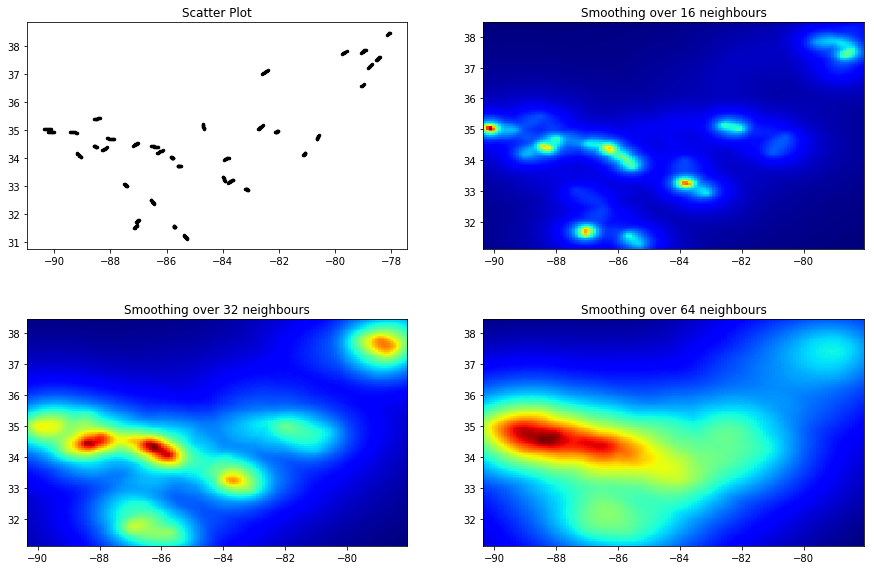

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, neighbours in zip(axes.flatten(), [0, 16, 32, 64]):

    if neighbours == 0:
        ax.plot(xs, ys, 'k.', markersize=5)
        ax.set_aspect('equal')
        ax.set_title("Scatter Plot")
    else:

        im = kNN2DDens(xv, yv, resolution, neighbours)

        ax.imshow(im, origin='lower', extent=extent, cmap=cm.jet)
        ax.set_title("Smoothing over %d neighbours" % neighbours)
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])

plt.savefig('new.png', dpi=300, bbox_inches='tight')

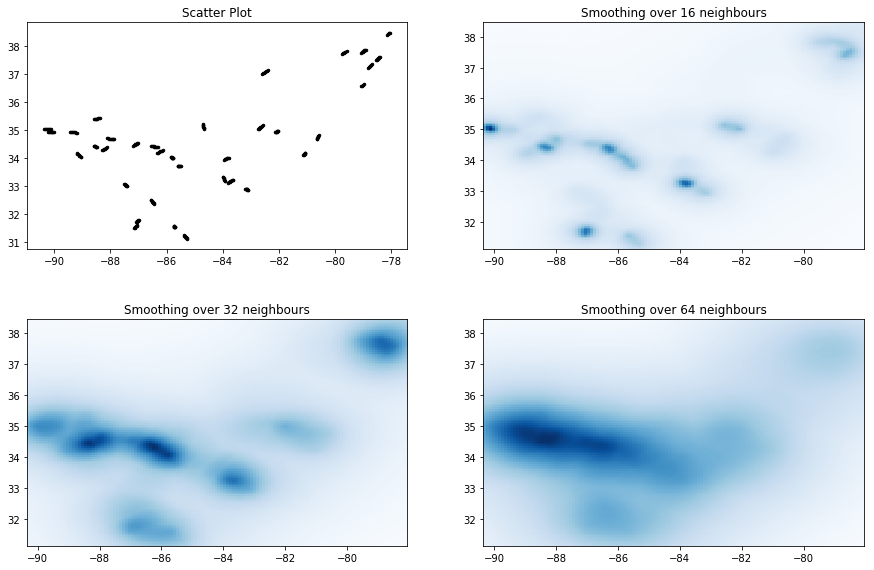

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, neighbours in zip(axes.flatten(), [0, 16, 32, 64]):

    if neighbours == 0:
        ax.plot(xs, ys, 'k.', markersize=5)
        ax.set_aspect('equal')
        ax.set_title("Scatter Plot")
    else:

        im = kNN2DDens(xv, yv, resolution, neighbours)

        ax.imshow(im, origin='lower', extent=extent, cmap=cm.Blues)
        ax.set_title("Smoothing over %d neighbours" % neighbours)
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])

plt.savefig('new.png', dpi=300, bbox_inches='tight')